In [1]:
import pandas as pd
import numpy as np
import librosa

In [2]:
#from scipy import stats

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import adam, sgd
#from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
from keras import regularizers
from keras.callbacks.callbacks import EarlyStopping

Using TensorFlow backend.


In [4]:
import scipy
import matplotlib.pyplot as plt
import librosa.display

In [5]:
import IPython.display as ipd
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

In [6]:
from sklearn.metrics import classification_report, confusion_matrix
import os
#import statistics

from random import randint, shuffle
import random
import itertools
import math
import time

In [13]:
import seaborn as sn
from random import shuffle, randint, seed

### Gathering files

In [8]:
root = "respiratory_sound_database/"
sound_dir = root + "audio_and_txt_files/"
patient_diagnosis = pd.read_csv(root+"patient_diagnosis.csv", names=["patient", "diagnosis"])
demographic_info = pd.read_csv(root+"demographic_info.txt", delimiter=" ", names=["patient", "age", "sex", "bmi", "weight", "height"])
train_soundfiles = pd.read_csv(root+"train_soundfiles.csv")
test_soundfiles = pd.read_csv(root+"test_soundfiles.csv")

In [9]:
patient_diagnosis.set_index("patient", inplace=True)
train_soundfiles.set_index("filename", inplace=True)
test_soundfiles.set_index("filename", inplace=True)

In [10]:
train_soundfiles.head()

""
filename
101_1b1_Al_sc_Meditron.wav
101_1b1_Pr_sc_Meditron.wav
102_1b1_Ar_sc_Meditron.wav
104_1b1_Al_sc_Litt3200.wav
104_1b1_Ar_sc_Litt3200.wav


## Defining hyperparameters

In [11]:
class Config(object):
    def __init__(self, n_mfcc, max_frames, sample_rate, max_audio_duration, batch_size, epochs):
        self.n_mfcc = n_mfcc
        self.max_frames = max_frames
        self.sample_rate = sample_rate
        self.max_audio_duration = max_audio_duration
        self.max_audio_length = max_audio_duration * sample_rate
        self.batch_size = batch_size
        self.epochs = epochs

In [12]:
config = Config(n_mfcc=40, max_frames=862, sample_rate = 11025, max_audio_duration = 20, batch_size = 64,
epochs = 700)

# Preprocessing

In [13]:
# Since we use CV, we don't need to differentiate between train and test
soundfiles = pd.concat([train_soundfiles, test_soundfiles])

In [14]:
#Input is the audio time series
def extract_features_from_sound(raw, config, verbose = 0):
    if (verbose == 1):
        print("Extracting features from sound...")
        print("Length of raw is", len(raw))
        
    max_audio_length = config.max_audio_length
    
    #Random padding
    if len(raw) < config.max_audio_length:
        maximum_padding = config.max_audio_length - len(raw)
        begin_padding = randint(a = 0, b = maximum_padding)
        end_padding = maximum_padding - begin_padding
        raw = np.pad(raw, pad_width=(begin_padding, end_padding), mode="constant")
    if (verbose == 1):
        print(len(raw))
    mfccs = librosa.feature.mfcc(y=raw, sr=config.sample_rate, n_mfcc=config.n_mfcc, hop_length=512, fmin=50, fmax=2000) 
    
    if (verbose == 1):
        print("Padding complete, length of raw is", len(raw))
        print("Padding, complete, shape of MFCCs is", np.array(mfccs).shape)
        print("Features from sound extracted!")
        
    return mfccs

In [15]:
#Given the patient number, return their diagnosis
def get_patient_diagnosis(patient):
    return patient_diagnosis.loc[patient].diagnosis

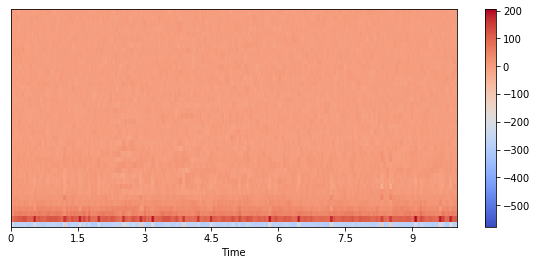

[[-5.7837762e+02 -2.7236804e+02 -1.9967609e+02 ... -2.7344678e+02
  -2.7533075e+02 -2.8213242e+02]
 [ 0.0000000e+00  7.2947433e+01  7.6097305e+01 ...  1.1166035e+02
   1.1414965e+02  1.0997243e+02]
 [ 0.0000000e+00  1.7816223e+01  2.1474392e+01 ...  5.2079285e+01
   5.4314590e+01  5.4089962e+01]
 ...
 [ 0.0000000e+00 -2.1703436e+00 -3.0259924e+00 ... -8.9168638e-01
  -2.5305321e+00 -1.0637765e+00]
 [ 0.0000000e+00 -8.3879590e-01 -1.6341736e+00 ...  2.5758188e+00
   1.7821709e+00 -4.8504639e+00]
 [ 0.0000000e+00 -1.6902518e+00 -2.3745804e+00 ... -1.2711786e+00
  -5.3051406e-01  6.3614788e+00]]
(40, 431)


In [16]:
#Example of the extract_features method at work
raw, sr = librosa.load(root + "audio_and_txt_files/154_2b4_Pl_mc_AKGC417L.wav", sr = config.sample_rate, duration=20)
sample_mfcc = extract_features_from_sound(raw, config)

plt.figure(figsize=(10,4))
librosa.display.specshow(sample_mfcc, x_axis='time')
plt.colorbar()
plt.show()

print(sample_mfcc)
print(sample_mfcc.shape)

COPD              566
Pneumonia          26
Healthy            24
URTI               14
Bronchiolitis       8
Bronchiectasis      7
Name: diagnosis, dtype: int64


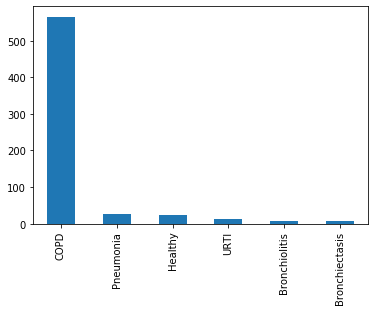

In [17]:
#Let's see what the data distribution is right now

train_diagnosis = []
for i, row in train_soundfiles.iterrows():
    patient = int(i.split("_")[0])
    diagnosis = patient_diagnosis.loc[patient]
    train_diagnosis.append(str(diagnosis[0]))
    
train_diagnosis = np.array(train_diagnosis)
train_diagnosis = pd.DataFrame(train_diagnosis, columns=["diagnosis"])
print(train_diagnosis.diagnosis.value_counts())
train_diagnosis.diagnosis.value_counts().plot(kind="bar")
diagnosis_value_counts = train_diagnosis.diagnosis.value_counts()

In [18]:
#Let's see what the data distribution is right now

def get_data_distribution(soundfiles, patient_diagnosis):
    train_diagnosis = []
    for i in soundfiles:
        patient = int(i.split("_")[0])
        diagnosis = get_patient_diagnosis(patient=patient)
        train_diagnosis.append(diagnosis)

    train_diagnosis = np.array(train_diagnosis)
    train_diagnosis = pd.DataFrame(train_diagnosis, columns=["diagnosis"])
    return train_diagnosis.diagnosis.value_counts()

In [19]:
classes = ["COPD", "Healthy", "Bronchiectasis", "URTI", "Pneumonia", "Bronchiolitis"]

In [20]:
#Let's increase the instances of classes other than COPD as much as we can.

### Extract MFCCs from soundfiles (X and y sets)

In [21]:
#Shuffling the data
soundfiles = soundfiles.sample(frac=1)

In [22]:
def generate_permutations(n, max = 90):
    p_out = [] #output permutations
    
    n_fac = math.factorial(n)
    if (max > n_fac):
        max = n_fac
    
    if (n <= 7):
        step = int((n_fac / max))
        p_out = list(itertools.islice(itertools.permutations(range(n)), 0, None, step))[:max]
        shuffle(p_out)
    else:
        i = 0
        while i < max:
            p = [] #permutation to be generated
            ids = list(range(n))
            for j in range(n): #pop indexes randomly
                p.append(ids.pop(randint(0, len(ids)-1)))
            if (p in p_out): #check if such permutation already exists
                continue #discard it and generate a new one
            else: #keep it and generate a new one
                i += 1
                p_out.append(p)
        
    return p_out

In [23]:
def get_data_for_cnn(soundfiles, directory, verbose = 0):
    all_features = [] #X
    all_diagnosis = [] #y
    
    diagnosis_value_counts = get_data_distribution(soundfiles, patient_diagnosis)
    
    for soundfile in soundfiles:
        
        #Reading loading necessary information
        annos = pd.read_csv(directory + soundfile[:-3] + "txt", 
                            names=["start", "end", "crackles", "wheezes"], 
                            delimiter="\t")
        raw, sr = librosa.load(directory + soundfile, sr=config.sample_rate, duration=config.max_audio_duration)
        if (verbose == 1):
            print("Soundfile", soundfile)
            print("Sample rate is", sr)
            print("Just loaded sound. Length is", len(raw))
            
        diagnosis = get_patient_diagnosis(int(soundfile[:3]))
        
        if (diagnosis == "COPD"):
            if (verbose == 1):
                print("Exctracting features for COPD...")
            features = extract_features_from_sound(raw, config, verbose = verbose)
            all_features.append(features)
            all_diagnosis.append(diagnosis)
            if(verbose ==1):
                print("Features extracted from COPD!")
        else:
            if(verbose == 1):
                print("Extracting features for", diagnosis)
            #Splitting sound into breath cycles
            raw_breath_cycles = []
            for i, row in annos.iterrows():
                start = int(np.floor(row.start * config.sample_rate))
                end = int(np.floor(row.end * config.sample_rate))
                raw_breath_cycles.append(raw[start:end])

            nr_perms_needed = int(np.floor(diagnosis_value_counts["COPD"] / diagnosis_value_counts[diagnosis])) - 1
            generated_perms = generate_permutations(len(raw_breath_cycles), nr_perms_needed)

            for perm in generated_perms:
                new_soundfile = []
                for i in perm:
                    new_soundfile.extend(raw_breath_cycles[i])
                new_soundfile = np.array(new_soundfile)
                all_features.append(extract_features_from_sound(new_soundfile, config, verbose = verbose))
                all_diagnosis.append(diagnosis)
            
            if (verbose == 1):
                print("Permutations complete!")
                
    X = np.expand_dims(np.array(all_features), -1)
    return X, all_diagnosis


In [25]:
#Removes patients with certain diagnosis from patient list
def remove_diagnosis(patient_list, diagnosis = ['LRTI', 'Asthma']):
    new_patient_list = []
    for patient in patient_list:
        if (get_patient_diagnosis(patient) in diagnosis):
            continue
        new_patient_list.append(patient)
    return new_patient_list

In [88]:
#Split patients into 5 folds
def get_patient_folds(patients_list, n_folds = 5, seed = 78):
    n_folds = 5
    m_patients_list = patients_list.copy()
    random.Random(4).shuffle(m_patients_list)
    fold_length = int(len(m_patients_list)/n_folds)
    patient_folds = []
    for i in range(n_folds-1):
        patient_folds += [m_patients_list[i*fold_length : (i+1)*fold_length]]
    patient_folds += [m_patients_list[(n_folds-1)*fold_length:]]
    return patient_folds

In [89]:
patient_folds = get_patient_folds(patients_list = patients_list)
m_patient_diagnosis = []
for fold in patient_folds:
    m_patient_diagnosis = []
    for patient in fold:
        m_patient_diagnosis.append(get_patient_diagnosis(patient))
    np_arr = np.array(m_patient_diagnosis)
    unique, counts = np.unique(np_arr, return_counts=True)
    print(dict(zip(unique, counts)))

{'Bronchiectasis': 2, 'COPD': 7, 'Healthy': 10, 'Pneumonia': 1, 'URTI': 4}
{'Bronchiolitis': 4, 'COPD': 10, 'Healthy': 6, 'Pneumonia': 3, 'URTI': 1}
{'Bronchiectasis': 1, 'Bronchiolitis': 1, 'COPD': 11, 'Healthy': 5, 'Pneumonia': 1, 'URTI': 5}
{'Bronchiectasis': 3, 'COPD': 15, 'Healthy': 2, 'Pneumonia': 1, 'URTI': 3}
{'Bronchiectasis': 1, 'Bronchiolitis': 1, 'COPD': 21, 'Healthy': 3, 'URTI': 1}


In [91]:
patients_list = remove_diagnosis(patient_diagnosis.index)

for i in range(50000):
    patient_folds = get_patient_folds(patients_list = patients_list, seed = i)
    found = True
    for fold in patient_folds:
        m_patient_diagnosis = []
        for patient in fold:
            m_patient_diagnosis.append(get_patient_diagnosis(patient))
        np_arr = np.array(m_patient_diagnosis)
        unique = np.unique(np_arr)
        if(len(unique) != 6):
            found = False
            break
    if (found == True):
        print(i)

In [97]:
def get_soundfiles_for_patients(patient_list):
    patient_soundfiles = []
    for soundfile in soundfiles.index:
        soundfiles_patient = int(soundfile[:3])
        if (soundfiles_patient in patient_list):
            patient_soundfiles.append(soundfile)
    return patient_soundfiles

In [ ]:
#Here we actually generate the augmented data and immediately save it to dataframes 
#(because it takes a while to generate the data)
# We do this for 5 folds here

patient_folds = get_patient_folds(patients_list)
start = time.time()
all_results = []

for i in range(1):
    print("We're at fold", i+1)
    test_patients = patient_folds[i]
    train_patients = patient_folds.copy()
    del train_patients[i]
    train_patients = [item for sublist in train_patients for item in sublist]
    
    test_soundfiles = get_soundfiles_for_patients(test_patients)
    train_soundfiles = get_soundfiles_for_patients(train_patients)
    
    X_train, labels_train = get_data_for_cnn(train_soundfiles, sound_dir)
    X_test, labels_test = get_data_for_cnn(test_soundfiles, sound_dir)
    
    all_labels = labels_train + labels_test
    test_labels_start = len(labels_train)
    factorized_labels, classes = pd.factorize(all_labels, sort=True)
    print(classes)
    if(len(classes) != 6):
        print("ERROR. Number of classes not 6.")
        print(classes)
        break
    categorical_labels = to_categorical(factorized_labels)
    y_train = categorical_labels[:test_labels_start]
    y_test = categorical_labels[test_labels_start:]
    
    np.save(root + "dataframes/X_train_04_10_split_" + str(i), X_train)
    np.save(root + "dataframes/X_test_04_10_split_" + str(i), X_test)
    np.save(root + "dataframes/y_train_04_10_split_" + str(i), y_train)
    np.save(root + "dataframes/y_test_04_10_split_" + str(i), y_test)
    
    ##GETTING THE RESULTS
    val_split = int(len(X_train)*0.2)
    X_val = X_train[:val_split]
    y_val = y_train[:val_split]
    X_train = X_train[val_split:]
    y_train = y_train[val_split:]

    model = get_model(config)
    history = model.fit(x=X_train, y=y_train, batch_size=config.batch_size, epochs=config.epochs,
          validation_data=(X_val, y_val), verbose=1)
    #model.save(root + 'models/model_cnn_disease_class_04-03_fold' + str(i) + ".h5")

    results = get_results_with_model(model, X_train, y_train, X_test, y_test)
    #all_results.append(results)

We're at fold 1


In [28]:
all_results = []

In [101]:
#After data generation, here is how you could use it for training
#Alternatively, you can modify the code to put all data info a single dataframe and create splits later

for i in range(1, 2):
    X_train = np.load(root + "dataframes/X_train_04_03_split_" + str(i)+".npy")
    X_test = np.load(root + "dataframes/X_test_04_03_split_" + str(i)+".npy")
    y_train = np.load(root + "dataframes/y_train_04_03_split_" + str(i)+".npy")
    y_test = np.load(root + "dataframes/y_test_04_03_split_" + str(i)+".npy")
    
    ##GETTING THE RESULTS
    val_split = int(len(X_train)*0.2)
    X_val = X_train[:val_split]
    y_val = y_train[:val_split]
    X_train = X_train[val_split:]
    y_train = y_train[val_split:]

    model = get_model(config)
    history = model.fit(x=X_train, y=y_train, batch_size=config.batch_size, epochs=config.epochs, validation_data=(X_val, y_val), verbose=1)    

Train on 2760 samples, validate on 690 samples
Epoch 1/700
2760/2760 [==============================] - 1s 361us/step - loss: 11.1840 - accuracy: 0.1812 - val_loss: 3.2070 - val_accuracy: 0.4101
Epoch 2/700
2760/2760 [==============================] - 0s 165us/step - loss: 3.6717 - accuracy: 0.2681 - val_loss: 3.1072 - val_accuracy: 0.3826

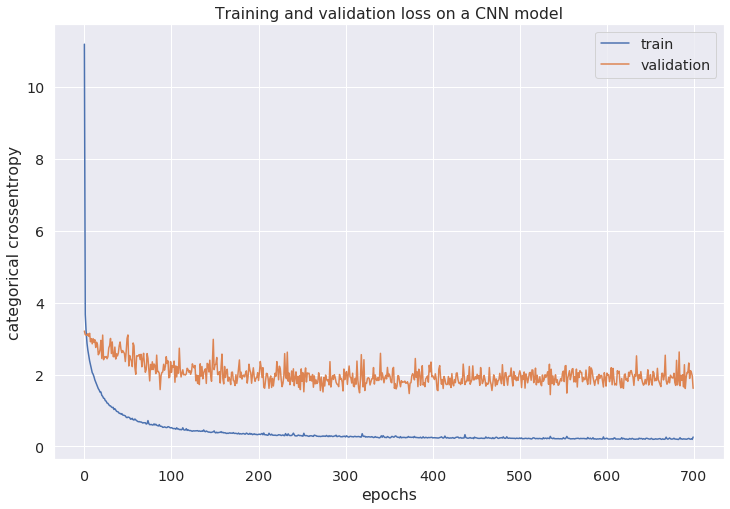

In [102]:
#summarizing history of training
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title("Training and validation loss on a CNN model")
plt.xlabel("epochs")
plt.ylabel("categorical crossentropy")
plt.legend()
plt.show()